In [1]:
import pandas as pd
import numpy as np
import qml
from qml.math import cho_solve
from qml.kernels import gaussian_kernel
from qml.kernels import laplacian_kernel


In [2]:

mols = [qml.Compound(xyz="./data/splitted_data/C6H6.xyz_"+ str(i)) for i in range(1, 10001)]


In [3]:
mols_representations = []
for mol in mols:
    mol.generate_coulomb_matrix(size=12, sorting="row-norm")
    mols_representations.append(mol.representation)

In [4]:
X = np.array(mols_representations)

In [5]:
np.save("./data/X.npy", X)

# KRR

In [3]:
X = np.load("./data/X.npy")

In [4]:
y = np.loadtxt("./data/E_def2-tzvp.dat")

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt


In [6]:
def qml_krr_gaussian(X_train, y_train, sigma, reg):
    K = gaussian_kernel(X_train, X_train, sigma)
    K[np.diag_indices_from(K)] += reg #Regularization
    alpha = cho_solve(K, y_train)
    return alpha

In [7]:
def qml_krr(X_train, y_train, sigma, reg):
    K = laplacian_kernel(X_train, X_train, sigma)
    K[np.diag_indices_from(K)] += reg #Regularization
    alpha = cho_solve(K, y_train)
    return alpha

In [8]:
def qml_krr_mae(X_train, y_train, X_test, y_test, sigma, reg):
    alpha = qml_krr(X_train, y_train, sigma, reg)
    Ks = laplacian_kernel(X_test, X_train, sigma)
    y_predicted = np.dot(Ks, alpha)
    mae = np.mean(np.abs(y_predicted - y_test))
    return mae

# Computations for learning curve

In [8]:
#%%timeit
qml_avg_mae_array = np.zeros((13,))
for j in range(1, 10):
    for i in range(1, 20):
        N = pow(2, i)
        if N > 10000:
            break
        X_copy = X.copy()
        y_copy = y.copy()
        np.random.seed(j)
        np.random.shuffle(X_copy)
        np.random.seed(j)
        np.random.shuffle(y_copy)
        X_train = X_copy[:N]
        y_train = y_copy[:N]
        avg_mae = 0
        X_test = X_copy[9001:]
        y_test = y_copy[9001:]
        qml_avg_mae_array[i-1] += qml_krr_mae(X_train, y_train, X_test, y_test, 4000, 1e-8)

qml_avg_mae_array /= 10

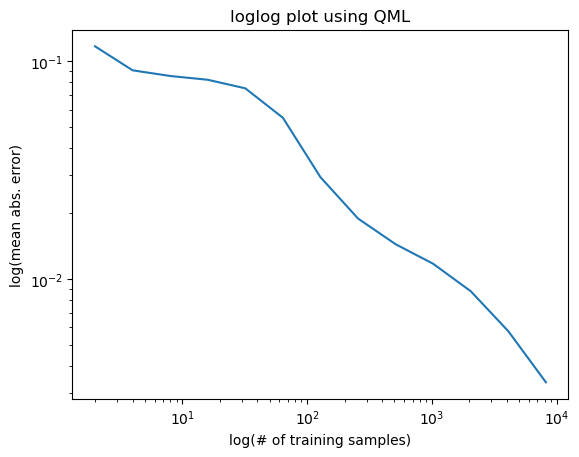

In [10]:
y_list = qml_avg_mae_array
x_list = [pow(2,i) for i in range(1, 14)]
plt.loglog(x_list, y_list)
plt.ylabel("log(mean abs. error)")
plt.xlabel("log(# of training samples)")
plt.title("loglog plot using QML")
plt.savefig("./img/ll_QML.png", dpi = 100)

In [9]:
def scikit_krr(X_train, y_train, sigma, reg):
    krr = KernelRidge(kernel = "laplacian", gamma = 1/sigma, alpha=reg)
    krr.fit(X_train, y_train)
    return krr

In [10]:
def scikit_krr_gaussian(X_train, y_train, sigma, reg):
    rbf_kernel(X_train)
    krr = KernelRidge(kernel = "rbf", gamma = 1/sigma, alpha=reg)
    krr.fit(X_train, y_train)
    return krr

In [11]:
def scikit_krr_mae(X_train, y_train, X_test, y_test, sigma, reg):
    krr = scikit_krr(X_train, y_train, sigma, reg)
    y_predicted = krr.predict(X_test)
    mae = np.mean(np.abs(y_predicted - y_test))
    return mae

# Computation for learning curve

In [13]:
#%%timeit
scikit_avg_mae_array = np.zeros((13,))
for j in range(1, 10):
    for i in range(1, 20):
        N = pow(2, i)
        if N > 10000:
            break
        X_copy = X.copy()
        y_copy = y.copy()
        np.random.seed(j)
        np.random.shuffle(X_copy)
        np.random.seed(j)
        np.random.shuffle(y_copy)
        X_train = X_copy[:N]
        y_train = y_copy[:N]
        avg_mae = 0
        X_test = X_copy[9001:]
        y_test = y_copy[9001:]
        scikit_avg_mae_array[i-1] += scikit_krr_mae(X_train, y_train, X_test, y_test, 4000, 1e-8)

scikit_avg_mae_array /= 10

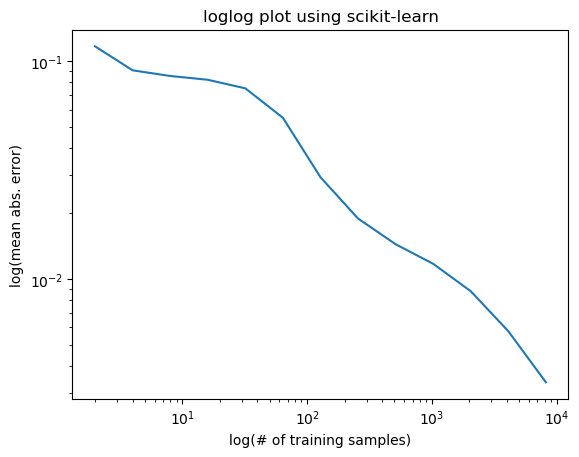

In [15]:
y_list = scikit_avg_mae_array
x_list = [pow(2,i) for i in range(1, 14)]
plt.loglog(x_list, y_list)
plt.ylabel("log(mean abs. error)")
plt.xlabel("log(# of training samples)")
plt.title("loglog plot using scikit-learn")
plt.savefig("./img/ll_scikit.png", dpi = 100)

# Time Benchmark for KRR

In [12]:
import time

In [13]:
scikit_wall_time_array = np.zeros((13,))
scikit_gaussian_wall_time_array = np.zeros((13,))
qml_wall_time_array = np.zeros((13,))
qml_gaussian_wall_time_array = np.zeros((13,))

for j in range(1, 3):
    for i in range(1, 20):
        N = pow(2, i)
        if N > 10000:
            break
        X_copy = X.copy()
        y_copy = y.copy()
        np.random.seed(j)
        np.random.shuffle(X_copy)
        np.random.seed(j)
        np.random.shuffle(y_copy)
        X_train = X_copy[:N]
        y_train = y_copy[:N]
        avg_mae = 0
        X_test = X_copy[9001:]
        y_test = y_copy[9001:]
        
        start = time.time()
        scikit_krr(X_train, y_train, 4000, 1e-8)
        end = time.time()
        scikit_wall_time_array[i-1] += end-start
        
        start = time.time()
        scikit_krr_gaussian(X_train, y_train, 4000, 1e-8)
        end = time.time()
        scikit_gaussian_wall_time_array[i-1] += end-start
        
        start = time.time()
        qml_krr(X_train, y_train, 4000, 1e-8)
        end = time.time()
        qml_wall_time_array[i-1] += end-start
        
        start = time.time()
        qml_krr_gaussian(X_train, y_train, 4000, 1e-8)
        end = time.time()
        qml_gaussian_wall_time_array[i-1] += end-start
        

scikit_wall_time_array /= 2
scikit_gaussian_wall_time_array /= 2
qml_wall_time_array /=2
qml_gaussian_wall_time_array /=2

In [14]:
scikit_cpu_time_array = np.zeros((13,))
scikit_gaussian_cpu_time_array = np.zeros((13,))
qml_cpu_time_array = np.zeros((13,))
qml_gaussian_cpu_time_array = np.zeros((13,))

for j in range(1, 3):
    for i in range(1, 20):
        N = pow(2, i)
        if N > 10000:
            break
        X_copy = X.copy()
        y_copy = y.copy()
        np.random.seed(j)
        np.random.shuffle(X_copy)
        np.random.seed(j)
        np.random.shuffle(y_copy)
        X_train = X_copy[:N]
        y_train = y_copy[:N]
        avg_mae = 0
        X_test = X_copy[9001:]
        y_test = y_copy[9001:]
        
        start = time.process_time()
        scikit_krr(X_train, y_train, 4000, 1e-8)
        end = time.process_time()
        scikit_cpu_time_array[i-1] += end-start
        
        start = time.process_time()
        scikit_krr_gaussian(X_train, y_train, 4000, 1e-8)
        end = time.process_time()
        scikit_gaussian_cpu_time_array[i-1] += end-start
        
        start = time.process_time()
        qml_krr(X_train, y_train, 4000, 1e-8)
        end = time.process_time()
        qml_cpu_time_array[i-1] += end-start
        
        start = time.process_time()
        qml_krr_gaussian(X_train, y_train, 4000, 1e-8)
        end = time.process_time()
        qml_gaussian_cpu_time_array[i-1] += end-start
        

scikit_cpu_time_array /= 2
scikit_gaussian_cpu_time_array /= 2
qml_cpu_time_array /=2
qml_gaussian_cpu_time_array /=2

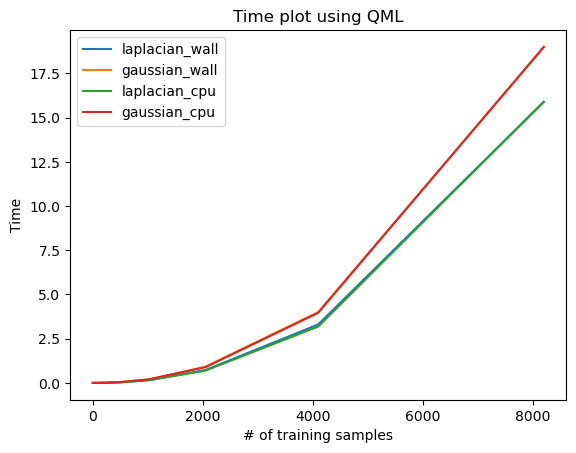

In [15]:
y_cpu_list = qml_cpu_time_array
y_cpu_gaussian_list = qml_gaussian_cpu_time_array
y_wall_list = qml_wall_time_array
y_wall_gaussian_list =  qml_gaussian_wall_time_array
x_list = [pow(2,i) for i in range(1, 14)]
plt.plot(x_list, y_wall_list, label = "laplacian_wall")
plt.plot(x_list, y_wall_gaussian_list, label = "gaussian_wall")
plt.plot(x_list, y_cpu_list, label = "laplacian_cpu")
plt.plot(x_list, y_cpu_gaussian_list, label = "gaussian_cpu")

plt.ylabel("Time")
plt.xlabel("# of training samples")
plt.title("Time plot using QML")
plt.legend()
plt.savefig("./img/Time_QML.png", dpi = 100)

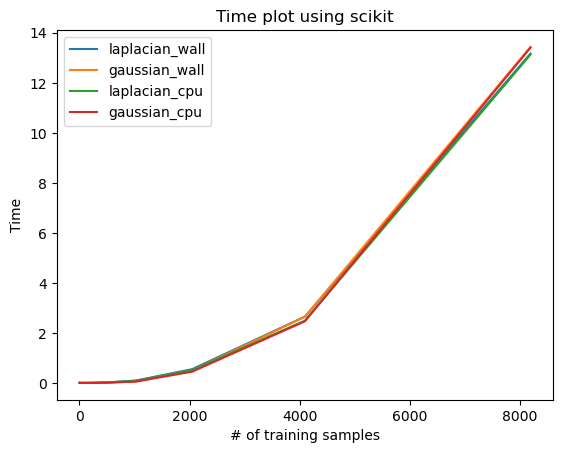

In [16]:
y_cpu_list = scikit_cpu_time_array
y_cpu_gaussian_list = scikit_gaussian_cpu_time_array
y_wall_list = scikit_wall_time_array
y_wall_gaussian_list =  scikit_gaussian_wall_time_array
x_list = [pow(2,i) for i in range(1, 14)]
plt.plot(x_list, y_wall_list, label = "laplacian_wall")
plt.plot(x_list, y_wall_gaussian_list, label = "gaussian_wall")
plt.plot(x_list, y_cpu_list, label = "laplacian_cpu")
plt.plot(x_list, y_cpu_gaussian_list, label = "gaussian_cpu")

plt.ylabel("Time")
plt.xlabel("# of training samples")
plt.title("Time plot using scikit")
plt.legend()
plt.savefig("./img/Time_scikit.png", dpi = 100)

# GridSearch for best hyperparameter

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

In [18]:
param_grid = {"alpha": [1e-8, 1.0, 10.0],
              "kernel": ["laplacian", "gaussian"],
              "gamma": [1/4000, 1/200, 10.0]}

In [20]:
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [24]:
grid_search = GridSearchCV(KernelRidge(), param_grid, cv=5, scoring=scorer)
grid_search.fit(X[:9000], y[:9000])

/home/ssunar/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ssunar/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ssunar/anaconda3/lib/python3.9/site-packages/sklearn/kernel_ridge.py", line 197, in fit
    K = self._get_kernel(X)
  File "/home/ssunar/anaconda3/lib/python3.9/site-packages/sklearn/kernel_ridge.py", line 155, in _get_kernel
    return pairwise_kernels(X, Y, metric=self.kernel, 

GridSearchCV(cv=5, estimator=KernelRidge(),
             param_grid={'alpha': [1e-08, 1.0, 10.0],
                         'gamma': [0.00025, 0.005, 10.0],
                         'kernel': ['laplacian', 'gaussian']},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [25]:
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean absolute error: ", -grid_search.best_score_)

Best hyperparameters:  {'alpha': 1e-08, 'gamma': 0.00025, 'kernel': 'laplacian'}
Best mean absolute error:  0.016087591261531455


In [26]:
sigma = 1/grid_search.best_params_['gamma']
alpha = grid_search.best_params_['alpha']

# GPR

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel

In [10]:
sigma = 4000
alpha = 1e-8

In [31]:
def scikit_gpr_mae(X_train, y_train, X_test, y_test, sigma, reg):
    kernel = PairwiseKernel(gamma = 1/sigma, metric = "laplacian")
    gpr = GaussianProcessRegressor(kernel=kernel, alpha = reg, random_state = 0).fit(X_train, y_train)
    y_predicted = gpr.predict(X_test)
    mae = np.mean(np.abs(y_predicted - y_test))
    return mae

In [32]:
gpr_scikit_avg_mae_array = np.zeros((13,))
for j in range(1, 10):
    for i in range(1, 20):
        N = pow(2, i)
        if N > 10000:
            break
        X_copy = X.copy()
        y_copy = y.copy()
        np.random.seed(j)
        np.random.shuffle(X_copy)
        np.random.seed(j)
        np.random.shuffle(y_copy)
        X_train = X_copy[:N]
        y_train = y_copy[:N]
        avg_mae = 0
        X_test = X_copy[9001:]
        y_test = y_copy[9001:]
        gpr_scikit_avg_mae_array[i-1] += scikit_gpr_mae(X_train, y_train, X_test, y_test, 4000, 1e-8)

gpr_scikit_avg_mae_array /= 10

/home/ssunar/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter gamma is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/ssunar/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/ssunar/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter gamma is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/ssunar/anaconda3/lib/python3.9/

KeyboardInterrupt: 

In [34]:
j

4

In [36]:
gpr_scikit_avg_mae_array /= 4

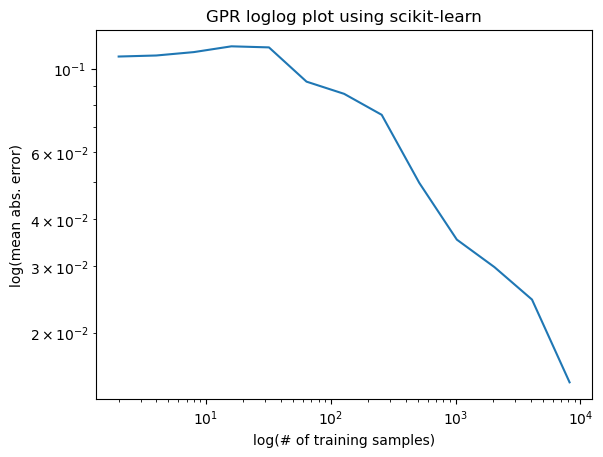

In [37]:
y_list = gpr_scikit_avg_mae_array
x_list = [pow(2,i) for i in range(1, 14)]
plt.loglog(x_list, y_list)
plt.ylabel("log(mean abs. error)")
plt.xlabel("log(# of training samples)")
plt.title("GPR loglog plot using scikit-learn")
plt.savefig("./img/gpr_scikit_lc.png", dpi = 100)

In [38]:
sum(range(1,13))

78